In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor

# classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import lightgbm as lgb

# for results
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

pd.set_option("display.max_rows", 10)

In [2]:
# import DNN & initial setting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [3]:
# load data
division = 'm'  # s or m (s = small-sized meeting room, m = medium-sized seminar room)

# session 1
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess1\S=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess1\S=*.csv')
l.sort()

df_fea_sess1 = []
for i in l:
    df_fea_sess1.append(pd.read_csv(i, header=None))

# session 2
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess2\S=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess2\S=*.csv')
l.sort()

df_fea_sess2 = []
for i in l:
    df_fea_sess2.append(pd.read_csv(i, header=None))
    
# session 3
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess3\S=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess3\S=*.csv')
l.sort()

df_fea_sess3 = []
for i in l:
    df_fea_sess3.append(pd.read_csv(i, header=None))

In [4]:
l

['..\\..\\datasets\\medium-room\\sess3\\S=0.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=1.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=2.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=3.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=4.csv']

In [5]:
# create column label (feature name)
# l(N1)_xxx(N2) >> N1: link number, N2: subcarrier number.

nof_link = 4
nof_usedsubc = 13

col_label = []

for i in range(nof_link):
    
    for j in range(nof_usedsubc):
        col_label.append('l%d_std%d' %(i+1,j+1))
        col_label.append('l%d_min%d' %(i+1,j+1))
        col_label.append('l%d_max%d' %(i+1,j+1))
        col_label.append('l%d_qtl%d' %(i+1,j+1))
        col_label.append('l%d_qtu%d' %(i+1,j+1))
        col_label.append('l%d_avg%d' %(i+1,j+1))
        
    for j in range(6):
        col_label.append('l%d_cur%d' %(i+1,j+1))
    for j in range(5):
        col_label.append('l%d_der%d' %(i+1,j+1))    

len(col_label)

356

In [6]:
# change column label

# sess1
for i in range(len(df_fea_sess1)):
    df_fea_sess1[i].columns = col_label
    
# sess2
for i in range(len(df_fea_sess2)):
    df_fea_sess2[i].columns = col_label
    
# sess3
for i in range(len(df_fea_sess3)):
    df_fea_sess3[i].columns = col_label

In [7]:
df_fea_sess1[0]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur2,l4_cur3,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,0.000003,-0.001783,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,0.000027,-0.002552,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,0.000040,-0.003094,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,0.000018,-0.002280,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,-0.000001,-0.001523,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2.234998,1.952983,1.642235,1.552838,1.686878,2.188347,2.466221,2.025162,1.933353,1.760320,...,0.000023,-0.001875,0.049112,-0.179824,10.048577,-3.035061e-07,0.000090,-0.005625,0.098223,-0.179824
395,2.136482,2.112427,1.756895,1.640038,1.605874,2.040877,2.245979,1.822832,1.856636,1.732509,...,0.000012,-0.001043,0.020199,0.219921,8.553810,-3.865501e-08,0.000048,-0.003129,0.040398,0.219921
396,2.320379,2.269228,1.839009,1.702551,1.535080,1.516574,1.428790,1.220235,1.294640,1.203857,...,0.000050,-0.003108,0.070145,-0.218774,8.743192,-1.336387e-06,0.000199,-0.009325,0.140289,-0.218774
397,2.107777,1.920989,1.682704,1.690026,1.659764,1.700245,1.649740,1.328510,1.216458,1.217324,...,0.000069,-0.004302,0.102801,-0.535439,8.660696,-1.910258e-06,0.000275,-0.012905,0.205601,-0.535439


In [8]:
# Ground truth

for i in range(len(df_fea_sess1)):
    df_fea_sess1[i]['GT'] = i  # GT: ground truth
    
for i in range(len(df_fea_sess2)):
    df_fea_sess2[i]['GT'] = i  # GT: ground truth
    
for i in range(len(df_fea_sess3)):
    df_fea_sess3[i]['GT'] = i  # GT: ground truth

In [9]:
df_fea_sess3[0]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur3,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5,GT
0,1.385663,1.646610,1.538554,1.465408,1.527942,1.248615,1.041441,0.846120,0.920258,0.852627,...,-0.001875,0.070656,-0.378192,8.503499,8.134954e-07,0.000019,-0.005625,0.141312,-0.378192,0
1,0.888026,0.958259,0.928159,0.900357,0.802910,0.736524,0.811240,0.713493,0.811425,0.721508,...,-0.001495,0.058187,-0.272544,8.775566,8.547522e-07,0.000003,-0.004486,0.116373,-0.272544,0
2,1.208987,1.202690,1.108639,1.038303,1.010439,0.971209,0.970304,0.848282,0.847092,0.722825,...,-0.002857,0.087423,-0.482713,8.777212,-1.353824e-07,0.000112,-0.008570,0.174846,-0.482713,0
3,1.192493,1.171755,1.057365,0.988108,0.961308,0.968901,0.993855,0.884732,0.825502,0.763991,...,-0.003633,0.094367,-0.450800,8.771725,-1.102314e-06,0.000201,-0.010898,0.188734,-0.450800,0
4,0.666737,0.685145,0.707628,0.730189,0.637604,0.686679,0.771845,0.754664,0.758890,0.728178,...,-0.002592,0.075482,-0.360921,8.878090,-2.384636e-07,0.000110,-0.007777,0.150964,-0.360921,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2.559110,2.627987,2.515883,2.539467,2.412636,2.489118,2.422848,1.899852,1.969385,1.918934,...,-0.003051,0.072784,-0.503230,11.511773,-1.647921e-06,0.000210,-0.009153,0.145568,-0.503230,0
395,2.528772,2.623832,2.591101,2.595341,2.456174,2.451556,2.297318,1.783503,1.860763,1.812023,...,-0.002420,0.049382,-0.003056,9.567947,-9.728965e-07,0.000155,-0.007260,0.098765,-0.003056,0
396,1.962211,1.962025,1.839681,1.744589,1.563168,1.448834,1.469259,1.535487,1.639640,1.631480,...,-0.001344,0.037480,0.012569,8.563748,2.164087e-07,0.000040,-0.004031,0.074961,0.012569,0
397,2.083318,2.310812,2.224580,2.370343,2.388922,2.661274,2.626539,2.062479,2.090601,2.005046,...,-0.000803,0.035585,-0.173559,8.930407,6.826692e-07,-0.000013,-0.002408,0.071169,-0.173559,0


In [10]:
df_sess1_tot = pd.DataFrame()
df_sess2_tot = pd.DataFrame()
df_sess3_tot = pd.DataFrame()

for i in df_fea_sess1:
    df_sess1_tot = pd.concat([df_sess1_tot, i], axis = 0)
    
for i in df_fea_sess2:
    df_sess2_tot = pd.concat([df_sess2_tot, i], axis = 0)
    
for i in df_fea_sess3:
    df_sess3_tot = pd.concat([df_sess3_tot, i], axis = 0)

In [11]:
df_sess1_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur3,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5,GT
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,-0.001783,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787,0
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,-0.002552,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390,0
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,-0.003094,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742,0
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,-0.002280,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525,0
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,-0.001523,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.917898,0.919850,0.856698,0.804004,0.727550,0.679315,0.650399,0.645671,0.707827,0.656676,...,0.000444,0.015425,-0.062696,10.424669,1.781041e-06,-0.000127,0.001333,0.030851,-0.062696,4
395,0.993171,1.055292,0.918394,0.886796,0.840524,0.783448,0.783273,0.697142,0.768202,0.650290,...,0.001289,-0.000815,-0.047433,10.910980,2.140359e-06,-0.000183,0.003866,-0.001630,-0.047433,4
396,0.913375,1.006806,1.072936,1.082991,1.013199,0.927840,0.883479,0.827988,0.818503,0.758421,...,0.000557,0.027969,-0.485448,11.351925,1.960868e-06,-0.000151,0.001671,0.055939,-0.485448,4
397,0.987489,1.093021,1.092624,1.122730,1.011742,0.943294,0.923651,0.845975,0.821050,0.787015,...,0.000407,0.029154,-0.436101,10.818459,2.029731e-06,-0.000146,0.001221,0.058308,-0.436101,4


In [12]:
# session number

df_sess1_tot['session'] = 1
df_sess2_tot['session'] = 2
df_sess3_tot['session'] = 3

In [13]:
df_sess1_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5,GT,session
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787,0,1
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390,0,1
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742,0,1
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525,0,1
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.917898,0.919850,0.856698,0.804004,0.727550,0.679315,0.650399,0.645671,0.707827,0.656676,...,0.015425,-0.062696,10.424669,1.781041e-06,-0.000127,0.001333,0.030851,-0.062696,4,1
395,0.993171,1.055292,0.918394,0.886796,0.840524,0.783448,0.783273,0.697142,0.768202,0.650290,...,-0.000815,-0.047433,10.910980,2.140359e-06,-0.000183,0.003866,-0.001630,-0.047433,4,1
396,0.913375,1.006806,1.072936,1.082991,1.013199,0.927840,0.883479,0.827988,0.818503,0.758421,...,0.027969,-0.485448,11.351925,1.960868e-06,-0.000151,0.001671,0.055939,-0.485448,4,1
397,0.987489,1.093021,1.092624,1.122730,1.011742,0.943294,0.923651,0.845975,0.821050,0.787015,...,0.029154,-0.436101,10.818459,2.029731e-06,-0.000146,0.001221,0.058308,-0.436101,4,1


In [14]:
df_sess_tot = pd.DataFrame()

df_sess_tot = pd.concat([df_sess_tot,df_sess1_tot], axis = 0)
df_sess_tot = pd.concat([df_sess_tot,df_sess2_tot], axis = 0)
df_sess_tot = pd.concat([df_sess_tot,df_sess3_tot], axis = 0)

df_sess_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5,GT,session
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787,0,1
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390,0,1
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742,0,1
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525,0,1
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,1.202281,1.290801,1.271125,1.305875,1.164755,1.178365,1.393361,1.390979,1.085079,1.281914,...,0.028248,-0.610571,13.497703,2.700868e-06,-0.000219,0.003090,0.056497,-0.610571,4,3
395,0.722978,0.720824,0.755536,0.760434,0.756769,0.859506,0.879017,0.809056,0.723456,0.669041,...,0.021852,-0.561359,12.149741,3.462881e-06,-0.000286,0.004833,0.043704,-0.561359,4,3
396,1.439172,1.433734,1.375746,1.396880,1.182754,1.100798,1.080205,0.930623,0.951749,0.980427,...,0.036868,-0.615200,10.564208,2.562863e-06,-0.000194,0.001927,0.073735,-0.615200,4,3
397,1.687076,1.663921,1.522277,1.425893,1.212331,1.112767,1.146947,1.055635,1.047915,0.989870,...,0.044606,-0.621023,10.649992,2.547312e-06,-0.000175,0.000799,0.089212,-0.621023,4,3


In [15]:
# row index reset

df_sess_tot = df_sess_tot.reset_index()
df_sess_tot = df_sess_tot.drop('index', axis = 1)

df_sess_tot

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5,GT,session
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787,0,1
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390,0,1
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742,0,1
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525,0,1
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,1.202281,1.290801,1.271125,1.305875,1.164755,1.178365,1.393361,1.390979,1.085079,1.281914,...,0.028248,-0.610571,13.497703,2.700868e-06,-0.000219,0.003090,0.056497,-0.610571,4,3
5981,0.722978,0.720824,0.755536,0.760434,0.756769,0.859506,0.879017,0.809056,0.723456,0.669041,...,0.021852,-0.561359,12.149741,3.462881e-06,-0.000286,0.004833,0.043704,-0.561359,4,3
5982,1.439172,1.433734,1.375746,1.396880,1.182754,1.100798,1.080205,0.930623,0.951749,0.980427,...,0.036868,-0.615200,10.564208,2.562863e-06,-0.000194,0.001927,0.073735,-0.615200,4,3
5983,1.687076,1.663921,1.522277,1.425893,1.212331,1.112767,1.146947,1.055635,1.047915,0.989870,...,0.044606,-0.621023,10.649992,2.547312e-06,-0.000175,0.000799,0.089212,-0.621023,4,3


In [16]:
# data seperation for leave-one-session-out

from sklearn.model_selection import LeaveOneGroupOut

sessions = df_sess_tot['session']
y = df_sess_tot['GT']

df_sess_tot2 = df_sess_tot.drop('session', axis = 1)
df_sess_tot2 = df_sess_tot2.drop('GT', axis = 1)

X = df_sess_tot2.copy()
X

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur2,l4_cur3,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,0.000003,-0.001783,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,0.000027,-0.002552,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,0.000040,-0.003094,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,0.000018,-0.002280,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,-0.000001,-0.001523,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,1.202281,1.290801,1.271125,1.305875,1.164755,1.178365,1.393361,1.390979,1.085079,1.281914,...,-0.000055,0.001030,0.028248,-0.610571,13.497703,2.700868e-06,-0.000219,0.003090,0.056497,-0.610571
5981,0.722978,0.720824,0.755536,0.760434,0.756769,0.859506,0.879017,0.809056,0.723456,0.669041,...,-0.000072,0.001611,0.021852,-0.561359,12.149741,3.462881e-06,-0.000286,0.004833,0.043704,-0.561359
5982,1.439172,1.433734,1.375746,1.396880,1.182754,1.100798,1.080205,0.930623,0.951749,0.980427,...,-0.000048,0.000642,0.036868,-0.615200,10.564208,2.562863e-06,-0.000194,0.001927,0.073735,-0.615200
5983,1.687076,1.663921,1.522277,1.425893,1.212331,1.112767,1.146947,1.055635,1.047915,0.989870,...,-0.000044,0.000266,0.044606,-0.621023,10.649992,2.547312e-06,-0.000175,0.000799,0.089212,-0.621023


In [17]:
# from dataframe to numpy

X = X.values
y = y.values

In [18]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups = sessions)

3

In [19]:
# early stopping setting
early_stopping =  EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

In [20]:
y_hot = to_categorical(y)
y_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

2022-02-14 16:19:32.534273
[0 4 0 ... 1 3 0]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
Epoch 1/10000
36/36 [==============================] - 1s 9ms/step - loss: 0.3200 - accuracy: 0.8850 - val_loss: 0.1454 - val_accuracy: 0.9674
Epoch 2/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0663 - accuracy: 0.9802 - val_loss: 0.1010 - val_accuracy: 0.9799
Epoch 3/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0520 - accuracy: 0.9855 - val_loss: 0.0495 - val_accuracy: 0.9825
Epoch 4/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0641 - val_accuracy: 0.9900
Epoch 5/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 0.0523 - val_accuracy: 0.9900
Epoch 6/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 0.0404 - val_

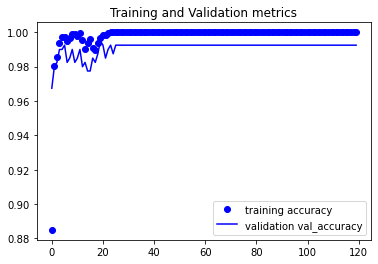

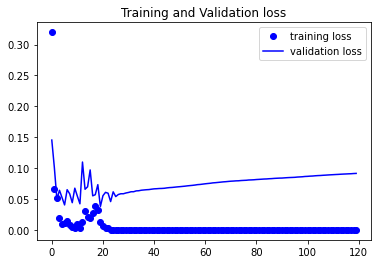

[0 4 0 ... 1 3 0]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
Epoch 1/10000
36/36 [==============================] - 1s 8ms/step - loss: 0.2244 - accuracy: 0.9295 - val_loss: 0.0737 - val_accuracy: 0.9850
Epoch 2/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0522 - accuracy: 0.9858 - val_loss: 0.0399 - val_accuracy: 0.9900
Epoch 3/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 0.0379 - val_accuracy: 0.9875
Epoch 4/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0138 - accuracy: 0.9953 - val_loss: 0.0231 - val_accuracy: 0.9925
Epoch 5/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9939 - val_loss: 0.0158 - val_accuracy: 0.9975
Epoch 6/10000
36/36 [==============================] - 0s 6ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0554 - val_accuracy: 0.9875
Epoch 7/10

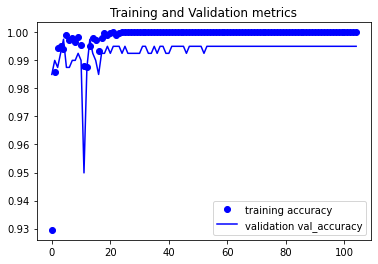

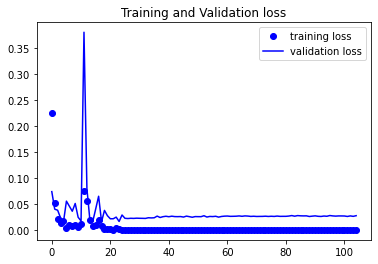

[0 4 0 ... 1 3 0]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
Epoch 1/10000
36/36 [==============================] - 1s 8ms/step - loss: 0.2599 - accuracy: 0.9223 - val_loss: 0.1178 - val_accuracy: 0.9749
Epoch 2/10000
36/36 [==============================] - 0s 5ms/step - loss: 0.0791 - accuracy: 0.9794 - val_loss: 0.1113 - val_accuracy: 0.9649
Epoch 3/10000
36/36 [==============================] - 0s 5ms/step - loss: 0.0466 - accuracy: 0.9866 - val_loss: 0.0676 - val_accuracy: 0.9649
Epoch 4/10000
36/36 [==============================] - 0s 5ms/step - loss: 0.0232 - accuracy: 0.9911 - val_loss: 0.0359 - val_accuracy: 0.9925
Epoch 5/10000
36/36 [==============================] - 0s 5ms/step - loss: 0.0078 - accuracy: 0.9972 - val_loss: 0.0268 - val_accuracy: 0.9900
Epoch 6/10000
36/36 [==============================] - 0s 5ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0715 - val_accuracy: 0.9699
Epoch 7/10

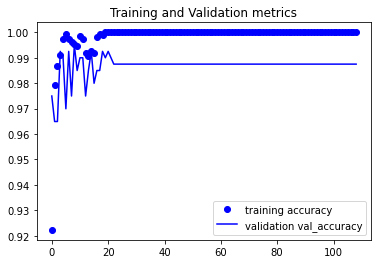

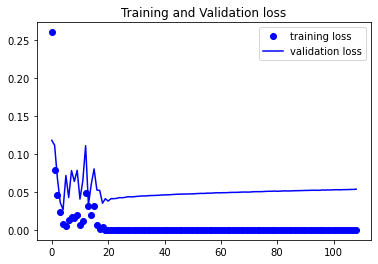

2022-02-14 16:20:44.046160


In [21]:
from sklearn.model_selection import train_test_split

result_y_test=[]
result_y_pred=[]

y_test_eachsess = [[],[],[]]
y_pred_eachsess = [[],[],[]]

count = 0

print(datetime.datetime.now())

for train_index, test_index in logo.split(X, y, sessions):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)

    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)
    
    y_train_hot = to_categorical(y_train)
    y_val_hot = to_categorical(y_val)

    print(y_train)
    print(y_train_hot)
    
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    opt = Adam(learning_rate=0.001)

    model.compile(optimizer=opt,  
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # fit
    history = model.fit(X_train, y_train_hot,  
                        batch_size=100,  
                        epochs=10000,     
                        verbose=1,      
                        validation_data=(X_val, y_val_hot), 
                        callbacks=(early_stopping))
        
    # prediction
    y_pred_hot = model.predict(X_test)
    y_pred = np.argmax(y_pred_hot, axis=1)
    
    # add result
    result_y_test.append(y_test)
    
    result_y_pred.append(y_pred)

    y_test_eachsess[count] = y_test
    y_pred_eachsess[count] = y_pred
    
    count += 1
    print(count)

    compare_TV(history, "accuracy", "val_accuracy")

print(datetime.datetime.now())

In [22]:
print("############## DNN #############")
print("accuracy: ",round(accuracy_score(np.array(result_y_test).flatten(),  np.array(result_y_pred).flatten()),3))
print(classification_report(np.array(result_y_test).flatten(),  np.array(result_y_pred).flatten()))
print(confusion_matrix(np.array(result_y_test).flatten(),  np.array(result_y_pred).flatten() ))

############## DNN #############
accuracy:  0.976
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1197
           1       0.99      0.98      0.99      1197
           2       0.98      0.99      0.99      1197
           3       0.99      0.97      0.98      1197
           4       0.97      0.98      0.98      1197

    accuracy                           0.98      5985
   macro avg       0.98      0.98      0.98      5985
weighted avg       0.98      0.98      0.98      5985

[[1152    7   10   12   16]
 [  15 1172    3    0    7]
 [  10    0 1184    1    2]
 [  22    0    7 1161    7]
 [  27    0    0    0 1170]]
